In [1]:
from json import load
from typing import Any
from pandas import DataFrame
from sys import path

path.append("../")

from src.utils.plots import cliff_delta_plot, make_errorplot


def prepare_dataframe_with_class_labels_columns(
    input_dict: dict[tuple[str, str, str], Any]
):
    df = DataFrame(input_dict, index=[0])

    df = df.unstack()
    # First, let's reset your DataFrame index
    df_reset = df.reset_index()
    df_reset = df_reset.drop(columns=["level_3"])
    # Then, rename your columns for clarity
    df_reset.columns = ["Class", "Component", "Feature", "correlation"]

    # Now, pivot your DataFrame
    df_pivot = df_reset.pivot(
        index="Class", columns=["Component", "Feature"], values="correlation"
    )

    # Display the result
    return df_pivot.T


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns


def make_plot(
    values_w_intervals: DataFrame,
    path_to_save: str,
    feature_names: list[str],
    classes_list: list[str] = ["positive", "negative"],
) -> None:
    # set the figure size using the golden ratio
    golden_ratio = (5**0.5 - 1) / 2
    figsize = 3

    # set seaborn style
    sns.set_style("darkgrid")

    # # set latex font
    plt.rcParams["mathtext.fontset"] = "stix"
    plt.rcParams["font.family"] = "STIXGeneral"

    # increase font size
    plt.rcParams.update({"font.size": 14})
    plt.rcParams['axes.grid'] = True

    fig, axs = plt.subplots(1, 3, figsize=(figsize / golden_ratio * 2, figsize))

    colors = sns.color_palette("colorblind", n_colors=2)

    for ax, component in zip(axs, ["mixed-EDA", "tonic-EDA", "phasic-EDA"]):
        for i, (event_type, event_actual_name) in enumerate(
            zip(["positive", "negative"], classes_list)
        ):
            make_errorplot(
                cliff_deltas=values_w_intervals,
                type_event=event_type,
                color=colors[i],
                ax=ax,
                custom_label=event_actual_name,
                elinewidth=10,
                markersize=2,
                component=component,
            )
        ax.set_title(component)

    axs[0]
    axs[1].set_ylim(0, 1)
    axs[2].set_ylim(0, 1)

    # set a horizontal line at 0.1 and -0.1
    for i, ax in enumerate(axs):
        ax.set_ylim(0, 1)
        if i == 0:
            ax.set_ylabel("Pearson's ρ")
            # set grid to False for y axis
            ax.grid(axis="y", which="both", linestyle="-", linewidth=0)
        else:
            ax.get_yaxis().set_visible(False)
        
        
        
        # set the x label to a 30º angle
        ax.set_xticklabels(
            feature_names, rotation=30, ha="right", fontsize=10, rotation_mode="anchor"
        )
        ax.tick_params(axis="x", which="major", pad=-3)
    # move the vertical grid lines to the right

    plt.subplots_adjust(
        left=None, bottom=None, right=None, top=None, wspace=0.01, hspace=None
    )
    plt.legend()
    plt.suptitle(
        "Pearson's ρ between left and right hand features", fontsize=16, y=1.05
    )
    plt.savefig(path_to_save, bbox_inches="tight")
    plt.show()


In [3]:
from pandas import merge, MultiIndex

def load_and_prepare_data(path_to_data: str) -> tuple[DataFrame, list[str]]:
    with open(path_to_data, "r") as f:
        cliff_delta_results = load(f)
        
    values = {
        (key1, key2, key3): val3[0]
        for key1, val1 in cliff_delta_results.items()
        for key2, val2 in val1.items()
        for key3, val3 in val2.items()
    }
    confidence_intervals = {
        (key1, key2, key3): str(val3[1])
        for key1, val1 in cliff_delta_results.items()
        for key2, val2 in val1.items()
        for key3, val3 in val2.items()
    }
    values = prepare_dataframe_with_class_labels_columns(values)
    confidence_intervals = prepare_dataframe_with_class_labels_columns(confidence_intervals)

    values_w_intervals = merge(
        left=values, right=confidence_intervals, left_index=True, right_index=True
    )
    values_w_intervals.columns = MultiIndex.from_tuples(
        [
            ("negative", "value"),
            ("positive", "value"),
            ("negative", "confidence interval"),
            ("positive", "confidence interval"),
        ]
    )
    values_w_intervals = values_w_intervals.dropna(how="any", inplace=False, axis=0)
    feature_names = values_w_intervals.index.get_level_values(1).unique().tolist()
    return values_w_intervals, feature_names

In [22]:
from ast import literal_eval

def compute_statistics(values_w_intervals, events: list[str] = ['positive', 'negative']):

    avg_neg = values_w_intervals[('negative', 'value')].mean()
    avg_pos = values_w_intervals[('positive', 'value')].mean()
    print(f'Average correlation for {events[0]}: {avg_pos:.2f}')
    print(f'Average correlation for {events[1]}: {avg_neg:.2f}')

    val_pos_bigger = 0
    val_neg_bigger = 0
    val_no_dif = 0
    for i in range(len(values_w_intervals)):
        negative_int = literal_eval(values_w_intervals[('negative', 'confidence interval')][i])
        positive_int = literal_eval(values_w_intervals[('positive', 'confidence interval')][i])
        if negative_int[0] > positive_int[1]:
            val_neg_bigger += 1
        elif positive_int[0] > negative_int[1]:
            val_pos_bigger += 1
        else:
            val_no_dif += 1
            
    val_pos_bigger = val_pos_bigger / len(values_w_intervals)
    val_neg_bigger = val_neg_bigger / len(values_w_intervals)
    val_no_dif = val_no_dif / len(values_w_intervals)

    print(f'Percentage of intervals where {events[0]} has larger correlation values: {val_pos_bigger*100:.2f}%')
    print(f'Percentage of intervals where {events[1]} has larger correlation values: {val_neg_bigger*100:.2f}%')
    print(f'Percentage of intervals where there is no difference: {val_no_dif*100:.2f}%')

# MWC2022

In [23]:
path_to_data = "../data.nosync/mwc2022/results/correlation_rl_features_complete.json"
values_w_intervals, feature_names = load_and_prepare_data(path_to_data)

In [25]:
compute_statistics(values_w_intervals=values_w_intervals, events=['sleep', 'awake'])

Average correlation for sleep: 0.49
Average correlation for awake: 0.46
Percentage of intervals where sleep has larger correlation values: 39.39%
Percentage of intervals where awake has larger correlation values: 12.12%
Percentage of intervals where there is no difference: 48.48%


/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_40102/236524874.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


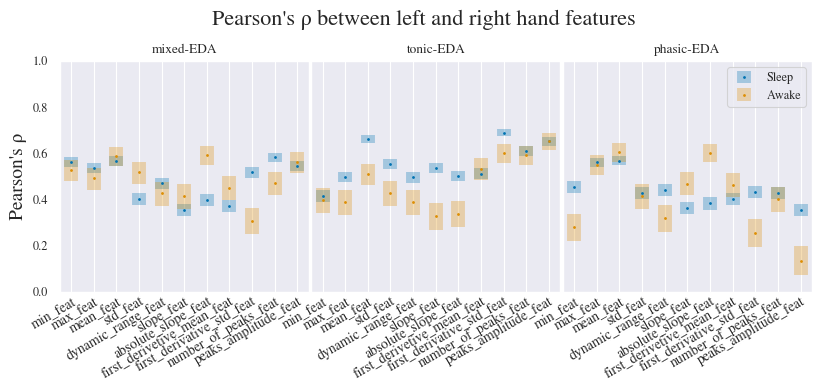

In [26]:

make_plot(
    values_w_intervals,
    "../final_visualizations/correlation_rl_complete-mwc2022.pdf",
    feature_names,
    classes_list=["Sleep", "Awake"],
)


# USILaughs

In [26]:
path_to_data = "../data.nosync/usilaughs/results/correlation_rl_features_complete.json"
values_w_intervals, feature_names = load_and_prepare_data(path_to_data)

In [28]:
compute_statistics(values_w_intervals=values_w_intervals, events=['Cognitive Load', 'Relaxation'])

Average correlation for Cognitive Load: 0.13
Average correlation for Relaxation: 0.14
Percentage of intervals where Cognitive Load has larger correlation values: 15.15%
Percentage of intervals where Relaxation has larger correlation values: 12.12%
Percentage of intervals where there is no difference: 72.73%


/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_40102/236524874.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


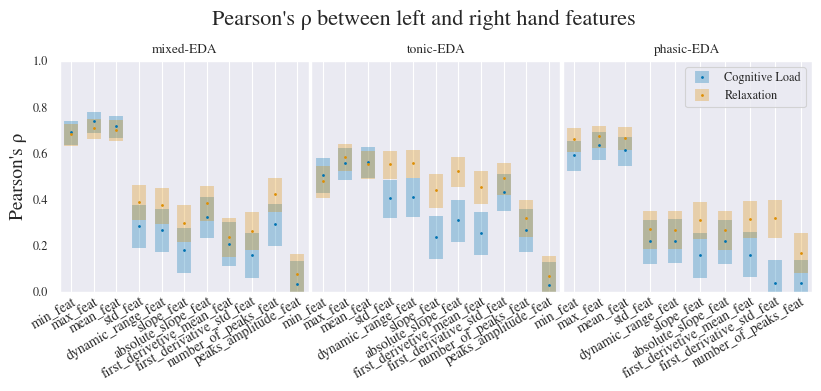

In [27]:
make_plot(
    values_w_intervals,
    "../final_visualizations/correlation_rl_complete-usilaughs.pdf",
    feature_names,
    classes_list=["Cognitive Load", "Relaxation"],
)
